In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from Functions import PredictiveAnalysis

import dash
from dash import html, dcc, ALL, MATCH, Output, Input, State, no_update, ctx, Patch
import dash_mantine_components as dmc
import dash_bootstrap_components as dbc


In [2]:
# load the clean data frame
df = pd.read_csv('final.csv')
df.head()

,Date,Year,Month,CSENT,IPM,HOUSE,UNEMP,LRIR,SP500,SP500_Price,SP500_Rise
0,1979-01-31,1979,1,-13.859020,7.862464,-5.157233,1.774952,-0.300399,11.966387,99.930000,1.0
1,1979-02-28,1979,2,-12.336892,7.786828,-8.596713,1.774952,-0.671270,10.615806,96.279999,1.0
2,1979-03-31,1979,3,-13.197970,6.418676,-2.579853,1.757858,-1.142366,13.877365,101.589996,1.0
3,1979-04-30,1979,4,-19.117647,2.997984,-13.425926,1.757858,-1.135133,5.091398,101.760002,1.0
4,1979-05-31,1979,5,-17.852835,3.917937,-15.169195,1.722767,-1.637674,1.892230,99.080002,1.0


### Test

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from Functions import Standardization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc
from dateutil.relativedelta import relativedelta

import plotly.express as px

class PredictiveAnalysis_Test(PredictiveAnalysis):
    def __init__(self, df):
        super().__init__(df)
        self.X = np.array([])
        self.y_num = np.array([])
        self.y_cat = np.array([])
        self.perf_df = {'LinR': pd.DataFrame(data=[], columns=['MA', 'FP', 'SC', 'RMSE', 'SE', 'R2', 'Adj-R2']),
                        'LogR': pd.DataFrame(data=[], columns=['MA', 'FP', 'SC', 'ACC', 'PRE', 'REC', 'F1', 'AUC']),
                        'CART': pd.DataFrame(data=[], columns=['MA', 'FP', 'SC', 'RMSE', 'SE', 'R2', 'Adj-R2'])}


    def create_data2(self, X_n: list, y_n: str, ma: list[int], fp: list[int], poly_d: int = 1):
        """
        Create the datasets (defined variables are shown below)
        - "self.X_name": list -> each feature name (including bias)
        - "self.X": NDArray -> applying polynomial and Standarization
        - "self.y_name": list -> each column's y name
        - "self.y_num" & "self.y_cat": NDArray -> applying moving averages 

        Parameters:
        - "X_n": input feature names
        - "y_n": target value name
        - "ma": moving average options for a target value
        - "fp": options of future prediction (month basis);
                 how many months of target values are predictd based on current data.
        - "poly_degree": degree of the polynomials
        """
        # update variables
        self.ma_opts = ma
        self.fp_opts = fp

        # X fetures matrix
        # apply polynomial
        self.poly = PolynomialFeatures(degree=poly_d, include_bias=True)
        X_poly = self.poly.fit_transform(self.df[X_n])
        # store all X names after polynomial transform
        self.X_name = self.poly.get_feature_names_out()
        # standardization
        self.scaler = Standardization()
        X_ss = self.scaler.fit_transform(120, X_poly[:, 1:])
        # add bias term
        self.X = np.c_[np.ones(X_ss.shape[0]), X_ss]

        # y matrix (each column shows different types of y)
        self.y_name = [f'{y_n}_{ma}MA' for ma in self.ma_opts]
        # initialize y matrix
        self.y_num = np.full((self.X.shape[0], len(self.y_name)), np.nan)
        self.y_cat = np.full((self.X.shape[0], len(self.y_name)), np.nan)
        # original y
        origin_y = np.array(self.df[y_n])
        for c, ma in enumerate(self.ma_opts):
            # apply moving averages (ma is 0 or 1 -> no moving averages)
            if ma < 2:
                self.y_num[:, c] = origin_y
                self.y_cat[:, c] = np.where(self.y_num[:, c] > 0, 1, 0)
            else:
                self.y_num[ma-1:, c] = np.array([np.mean(origin_y[i-ma:i], axis=0) for i in range(ma, len(origin_y)+1)])
                self.y_cat[ma-1:, c] = np.where(self.y_num[ma-1:, c] > 0, 1, 0)


    def model_learning2(self, scopes: list, model: str = '', X_use: list = [], eta_: float = 0.01, alpha_: float = 1, lambda_: float = 0.5, iter_: int = 100):
        """
        Define and return three types of figures
        - "self.compere_perf_fig": comparing performance with respect to evaluation metrics.
        - "self.be_test_fig": result of the backward elimination with respect to scopes.
        - "self.coef_dev_fig": development of thetas(coefficisnts) over time.
        
        Parameters:
        - "scopes": how much previous data should be considered to update the parameters next step.
        - "model": either one of ['LinR', 'LogR', 'CART'].
        - "X_use": the list of feature names that are used for the model training.
        - "eta_": learning rate of each gradient descent.
        - "alpha_": degree of how strong the regularizations are.
        - "lambda_": balancer between l2 and l1 norm.
        - "iter_": maximum iteration of parameter updates at each step
        """
        # define variable
        self.sc_opts = scopes
        # define X feature index that will be used for model training
        if not X_use:
            self.X_use_idx = [i for i in range(len(self.X_name))]
        else:
            self.X_use_idx = [0] + list(np.where(np.in1d(self.X_name, X_use))[0])

        # set hyperparameters globally
        self.eta_ = eta_
        self.alpha_ = alpha_
        self.lambda_ = lambda_
        self.iter_ = iter_

        # set spaces (initialize)
        self.results = {model: {f'{i}FP': {} for i in self.fp_opts} for model in ['LinR', 'LogR', 'CART']}
        self.be_tests[model] = {sc: [] for sc in scopes}
        self.futures[model] = {f'{k1}FP': {f'{k2}MA': np.zeros((len(scopes), k1)) for k2 in self.ma_opts} for k1 in self.fp_opts}

        idx = 0
        # each moving average
        for i, ma in enumerate(self.ma_opts):
            # each future prediction
            for fp in self.fp_opts:
                # each scope
                for j, sc in enumerate(self.sc_opts):
                    # linear regression
                    if model == 'LinR':
                        theta, y_hat, error, future = self.linear_reg2(X=self.X[:, self.X_use_idx], y=self.y_num[:, [i]], t=120, fp=fp, sc=sc)
    
                    elif model == 'LogR':
                        theta, y_hat, error, future = self.logistic_reg2(X=self.X[:, self.X_use_idx], y=self.y_cat[:, [i]], t=120, fp=fp, sc=sc)

                    elif model == 'CART':
                        theta, y_hat, error, future = None, None, None, None

                    else:
                        raise TypeError('Choose one of following model names: "LinR", "LogR", and "CART".')
                    
                    # store all results
                    self.results[model][f'{fp}FP'].update({f"{ma}MA_{sc}SC": {'theta': theta, 'y_hat': y_hat, 'error': error}})
                    # store future values
                    self.futures[model][f'{fp}FP'][f'{ma}MA'][j] = future

                    # get test result of backward elimination
                    y_vec = self.y_cat[:, [i]] if model == 'LogR' else self.y_num[:, [i]]
                    be_test_df = self.evaluation2(model, self.X[:, self.X_use_idx], y_vec, 120, theta, y_hat, error, fp)
                    # retrienve only performance without any changes in each coefficient
                    self.perf_df[model].loc[idx] = [ma, fp, sc] + list(be_test_df.iloc[0])
                    # store its result as NDArray
                    self.be_tests[model][sc].append(np.array(be_test_df))

                    # increment idx
                    idx += 1

        self.compere_perf_fig = self.compare_perf(model)
        self.be_test_fig = self.backward_elimination(model)
        self.coef_dev_fig = self.coefs_develop2(model)

        return self.compere_perf_fig, self.be_test_fig, self.coef_dev_fig

    def linear_reg2(self, X, y, t, fp, sc):
        """
        Return the following four matrix (dtype: np.array)
        - "thetas"  -> parameters (intercept + coefficients) at each step
        - "y_hats" -> predicted values at each step
        - "errors"  -> prediction errors (actual - predicted values); SSE
        - "future" -> Predicted values based on the rest of features

        Parameters:
        - "X": np.array -> independent variables
        - "y": np.array -> target variables
        - "t": int -> number of data that were used for the initial parameter creation.
        - "fp": the performance of certain months of future
        - "sc": int -> scope of the latest data for parameter updates
        
        """
        # define all matrix to be returned
        thetas = np.full((X.shape[0]-t, X.shape[1]), np.nan)
        y_hats = np.full((X.shape[0]-t, 1), np.nan)
        errors = np.full((X.shape[0]-t, 1), np.nan)
        
        # initial training
        init_X, init_y = X[0:t], y[fp:t+fp]
        # obtain the initial parameters based on normal equation form
        thetas[:fp] = np.linalg.inv(init_X.T.dot(init_X)).dot(init_X.T).dot(init_y).reshape(1,-1)

        # define elastic net gradient
        def gradient(X, y, theta, n=sc, a_=self.alpha_, l_=self.lambda_):
            # gradient
            grad = -2/n * (np.dot(X.T, y - np.dot(X, theta.T))).T
            d_l1 = l_ * a_ * np.sign(theta)
            d_l2 = (1 - l_) * a_ * theta
            return grad + d_l1 + d_l2

        # incremental learnings (as long as actual target is available)
        i = 0
        while t+fp < len(y):
            # get new data at the time 't'
            X_t, y_t = X[t] , y[t+fp]
            # predicted variable of 'fp' months ahead
            y_hats[i+fp] = np.dot(X_t, thetas[i])
            # predicted error 
            errors[i+fp] = (y_hats[i+fp] - y_t)
            # define subset of X and y
            X_sub, y_sub = X[t-sc+1:t+1], y[t+fp-sc+1:t+fp+1]
            # get the current theta
            theta_ = thetas[[i]]
            # iterations
            for _ in range(self.iter_):
                # get the gradient of MSE with elastic net regularization
                grad = gradient(X_sub, y_sub, theta_)
                # update the theta
                theta_ -= self.eta_* grad
            # assign finialized theta
            thetas[i+fp] = theta_

            # increment t and idx
            t += 1
            i += 1

        # calculate the future values
        future = np.sum(np.multiply(X[-fp:], thetas[i:]), axis=1)
        
        return thetas, y_hats, errors, future

    def logistic_reg2(self, X, y, t, fp, sc):
        """
        Return the following five matrix (dtype: np.array)
        - "thetas"  -> parameters (intercept + coefficients) at each step
        - dictionary: predicted y values:
            - "cat" key: "y_preds_c" -> predicted labels at each step
            - "proba" ley: "y_preds_p" -> predicted probability at each step (nagetige & positive class)
        - "errors"  -> prediction errors (actual - predicted values); SSE
        - dictionary: future y values 
            - "cat": predicted labels at each step
            - "proba": probability of the positive class label

        Parameters:
        - "X": np.array -> independent variables
        - "y": np.array -> target variables (shouold be categorical)
        - "t": int -> number of data that were used for the initial parameter creation.
        - "sc": int -> scope of the latest data for parameter updates.
        """
        # define sigmoid function
        def sigmoid(h):
            return 1 / (1 + np.exp(-h))

        # calculate the gradient vector
        def gradient(X, y, theta, w, alpha_, lambda_):
            m = len(y)
            preds = sigmoid(np.dot(X, theta.reshape(-1,1)))
            grad = -np.dot(X.T, np.multiply(y - preds, w)) / m
            l1 = lambda_ * np.sign(theta)
            l2 = (1 - lambda_) * theta

            return grad.T + alpha_ * (l1 + l2)
        
        # initialize matrics to store values at each step
        thetas = np.full((X.shape[0]-t, X.shape[1]), np.nan)
        y_hats = np.full((X.shape[0]-t, 1), np.nan)
        errors = np.full((X.shape[0]-t, 1), np.nan)
        # initial training 
        init_X, init_y = X[0:t], y[fp:t+fp]
        logit = LogisticRegression(fit_intercept=False, class_weight='balanced')
        logit.fit(init_X, init_y.flatten())
        # set initial parameters
        thetas[:fp] = logit.coef_

        # incremental learnings (as long as actual target is available)
        i = 0
        # counting unique numbers
        y_ex_nan = y[~np.isnan(y)]
        count_labels = {k: np.sum(y_ex_nan[:t] == k) for k in np.unique(y_ex_nan)}
        while t+fp < len(y):
            # get new data at the time 't'
            X_t, y_t = X[[t]] , y[t+fp]
            # predicted variable of 'fp' months ahead
            y_hats[i+fp] = sigmoid(np.dot(X_t, thetas[i]))
            # predicted error 
            errors[i+fp] = (y_hats[i+fp] - y_t)
            # increment counts of unique labels
            count_labels[y_t[0]] += 1
            # calculate weights
            weights = {k: sum(count_labels.values()) / (2 * v) for k, v in count_labels.items()}
            w_vect = np.vectorize(weights.get)
            # logistic loss
            y_proba = {0: 1-y_hats[i+fp], 1: y_hats[i+fp]}
            errors[i+fp] = -1 * weights[y_t[0]] * np.log(y_proba[y_t[0]])
            # define subset of X and y
            X_sub, y_sub = X[t-sc+1:t+1], y[t+fp-sc+1:t+fp+1]
            # get the current theta
            theta_ = thetas[[i]]
            # iterations
            for _ in range(self.iter_):
                # get the gradient
                grad = gradient(X_sub, y_sub, theta_, w_vect(y_sub), self.alpha_, self.lambda_)
                # update the theta
                theta_ -= self.eta_* grad.flatten()
           
            # assign finialized theta
            thetas[i+fp] = theta_

            # increment t and idx
            t += 1
            i += 1

        # predict the future labels
        future = sigmoid(np.sum(np.multiply(X[-fp:], thetas[i:]), axis=1))

        return thetas, y_hats, errors, future 
        

    def evaluation2(self, model, X, y, t, thetas, y_hats, errors, fp):
        """
        Return the data frame; the following measureas:
        (1): Numerical Target Value
            - Root Mean Square Error (rmse)
            - Standatd Error of Estimate (se)
            - Coefficient of Determination (r2)
            - Adjusted Coefficient of Determination (adj_r2)

        (2): Categorical Target Value
            - Accuracy (acc)
            - Precsion (pre)
            - Recall (rec)
            - F1 Score (f1)
            - Area Under the ROC Curve (auc)

        Parameters:
        - "model": either one of ['LinR', 'LogR', 'CART']
        - "t": number of months that were used for the initial training data.
        - "X": independent variables
        - "y": the actual target value (whole period)
        - "theta": all parameters (intercept & coefficients) at each step
        - "y_hats": the predicted target value at each step
        - "error": difference between actual and predicted values at each step

        Requirement: len(y[t:]) == len(y_hats)
        """
        # define feature matrix and target that were used for incremental learning
        X_, y_ = X[t:-fp], y[t+fp:]
        #  number of observations features (excluding bias)
        n, k = X_.shape[0], X.shape[1] - 1
        # assign the data frame index and columns
        rows = ['original'] + [f'theta{i}=0' for i in self.X_use_idx[1:]]

        # define measures based on model
        if model == 'LinR':
            # names of the measure
            cols = ['rmse', 'se', 'r2', 'adj_r2']
            # measures matrix
            mm = np.zeros((k+1, len(cols)))
            # sum of square total
            sst = np.sum((y_ - np.mean(y_))**2)
            #  number of coefficients
            for i in range(k+1):
                # simply applying the given error
                if i == 0:
                    error_ = errors[fp:]
                # conduct the backward elimination
                else:
                    # copy the parameters matrix
                    theta_ = thetas[:-fp].copy()
                    # change a particular coefficient to 0 arbitrarily.
                    theta_[:, i] = 0
                    # based on revised parameters, get the predicted value
                    y_hats_ = np.sum(X_ * theta_, axis=1).reshape(-1, 1)
                    # predicted error
                    error_ = y_ - y_hats_    
            
                # Calculate Measures (rmse, se, r2, adj_r2, in order)
                sse = np.sum(error_**2)
                mm[i, 0] = np.sqrt((error_**2).mean()) 
                mm[i, 1] = np.sqrt(sse / (n - k - 1))
                mm[i, 2] = 1 - sse/sst
                mm[i, 3] = 1 - (sse/(n - k -1))/(sst/(n-1))

            return pd.DataFrame(data=mm, index=rows, columns=cols)

        elif model == 'LogR':
            # define functions to generate classification measures from confusion matrix
            def measures_from_cm(cm):
                tn, fp, fn, tp = cm.ravel()
                #calculate the metrics
                acc = (tp + tn) / np.sum(cm)  # accuracy
                prec = tp / (tp + fp)  # precision
                rec = tp / (tp + fn)  # recall
                f1 = 2 * prec * rec / (prec + rec)  # f1 score
                fpr = fp / (fp + tn)  # false positive rate
                tpr = tp / (tp + fn)  # true positive rate
                # points for roc
                roc_points = [(0, 0), (fpr, tpr), (1, 1)]
                auc_ = auc([p[0] for p in roc_points], [p[1] for p in roc_points])

                return [acc, prec, rec, f1, auc_]
            
            # names of the measures
            cols = ['acc', 'pre', 'rec', 'f1', 'auc']
            # measures matrix
            mm = np.zeros((k+1, len(cols)))
            #  number of coefficients
            for i in range(k+1):
                # simply applying the predicted label
                if i == 0:
                    y_hats_ = np.where(y_hats[fp:] >= 0.5, 1, 0)
                # conduct the backward elimination
                else:
                    # copy the parameters matrix
                    theta_ = thetas[:-fp].copy()
                    # change a particular coefficient to 0 arbitrarily.
                    theta_[:, i] = 0
                    # based on revised parameters, get the predicted value
                    hx = np.sum(X_ * theta_, axis=1).reshape(-1, 1)
                    y_hats_ = np.where(1 / (1 + np.exp(-hx)) >= 0.5, 1, 0)
            
                # confusion matrix
                cm = confusion_matrix(y_, y_hats_)
                # assign each measure              
                measures = measures_from_cm(cm)
                for j, val in enumerate(measures):
                    mm[i, j] = val

            return pd.DataFrame(data=mm, index=rows, columns=cols)

        else:
            raise(TypeError("Model should be either one of ['LinR', 'LogR', 'CART']"))

    def coefs_develop2(self, model: str):
        """
        Generate the development of each coefficient impacts over time on average.

        Parameters:
        - "model": either one of defined model names; "LinR" and "LogR"

        """
        # get the minimum theta dimentions (ecluding bias term)
        max_fp, max_ma, first_sc = max(self.fp_opts), max(self.ma_opts), self.sc_opts[0]
        thetas_dim = self.results[model][f'{max_fp}FP'][f'{max_ma}MA_{first_sc}SC']['theta'][:, 1:].shape
        min_thetas_dim = (thetas_dim[0]-max_fp, thetas_dim[1])
        # get the last date of data frame
        last_date = pd.to_datetime(self.df['Date'].iloc[-1])
        # get the next month last date
        next_month_last = last_date + relativedelta(months=1)
        # define start date
        start_date = next_month_last - relativedelta(months=min_thetas_dim[0]-1)
        # define date ranges
        date_ranges = np.array(pd.date_range(start_date, next_month_last, freq='M'))
        # define data frame
        thetas_df = pd.DataFrame({"Date": date_ranges})

        # initialize thetas data
        thetas_data = np.zeros(min_thetas_dim)
        denominator = 0
        # get all thetas from multiple models
        for k1 in self.results[model].keys():
            fp = int(k1[0])
            for k2 in self.results[model][k1].keys():
                # index start and end
                s, e = max_fp - fp+1, thetas_dim[0] - fp + 1
                thetas_data += self.results[model][k1][k2]['theta'][s:e, 1:]
                denominator += 1

        # calculate mean
        thetas_mean = thetas_data / denominator
        # define column names
        cols = [self.X_name[i] for i in self.X_use_idx[1:]]
        # adding thetas_data
        thetas_df = pd.concat([thetas_df, pd.DataFrame(thetas_mean, columns=cols)], axis=1)
        
        # create visualizations
        fig = px.line(thetas_df, 'Date', cols)
        for trace in fig.data:
            trace.hovertemplate = f'%{{y}}'

        fig.update_layout(
            title='Impact of Economic Indicators on S&P500 Over Time',
            legend=dict(title_text='Indicators', orientation='h', font_size=11, font_color='lightgray',
                        x=-0.025, y=1.05, xanchor='left', yanchor='top'),
            template='plotly_dark', hovermode="x unified",
            yaxis=dict(title_text='Strengths'),
            height=400, width=800, margin=go.layout.Margin(t=60, b=50, l=50, r=30),
            )
        
        return fig


test = PredictiveAnalysis_Test(df)
test.create_data2(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR'], 'SP500', ma=[1,2,3], fp=[2,4], poly_d=1)
a,b,c=test.model_learning2([1, 6, 12, 60], model='LogR')
#print(thetas.shape, y_hats.shape, errors.shape, future.shape)

KeyboardInterrupt: 

# Dataset Creation
- Six types of moving averages ; from one to six months.
- Six types of dataset shifts; from one to six months.

In [ ]:
"""
class PredictiveAnalysis_Test(PredictiveAnalysis):
    def __init__(self, df):
        super().__init__(df)
"""

'\nclass PredictiveAnalysis_Test(PredictiveAnalysis):\n    def __init__(self, df):\n        super().__init__(df)\n'

In [3]:
PA = PredictiveAnalysis(df)
PA.create_data(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR'], 'SP500', ma=[1,2,3], fp=[1,2,3,4,5,6], poly_d=1)

In [9]:
print(PA.X[:5], PA.y_num[:5], PA.y_cat[:5])

[[ 1.         -0.81007907 -0.35272387 -0.94132115 -0.62143464 -2.67350137]
 [ 1.         -0.98012004 -0.4397087  -1.08791838 -0.62143464 -2.22775016]
 [ 1.         -1.54193035 -0.68981318 -1.68639999 -0.62143464 -2.40320432]
 [ 1.         -1.73714365 -0.76351427 -2.09618965 -0.16400466 -3.04839324]
 [ 1.         -2.01578157 -1.60827927 -1.49801194  0.25525995 -3.16751171]] [[14.23997129 13.27439297 12.88338872]
 [18.05152171 16.1457465  14.86676922]
 [ 0.49217444  9.27184808 10.92788915]
 [ 4.45164965  2.47191205  7.66511527]
 [12.27290655  8.3622781   5.73891021]] [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


# Model Creation & Evaluation

- Four machine learning models
    1. Multiple Linear Regression
    3. Logistic Regression
    4. Classification and Regression Tree

<br>

- Evaluations
    - Regressions:
        - <b>Root Mean Square Error (RMSE)</b>: How much errors could occur between the predicted prices and the actual ones.
        - <b>Standard Error of Estimate (SE)</b>: How much variation could occur in the actual target based on the same condition of independent variables. 
        - <b>Coffeficient of Determination (R2)</b>: How well the regression model explains the variation of a target value.
        - <b>Adjusted R2</b>: R2 with the penalty for the number of independent variables.
        <br><br>
        
    - Classification
        - <b>Accuracy</b>: How the model can correctly predict the target values.
        - <b>Precision</b>: How the model can avoid false positives.
        - <b>Recall</b>: How the model can avoid false negatives.
        - <b>F1 Score</b>: How the model can balance precision and recall.
        - <b>AUC (Area Under the ROC Curve)</b>: How the model can summarize the ROC curve.

### Multiple linear Regression
- Applying different scopes for parameter adjustments; [1,2,3,4,5,6]
- Feature selection by backward elimination for whole models.

In [10]:
# define function to plot vix horizontally

def horizon_plots(figs, model,**subplots_arg):
    perf_figs = make_subplots(rows=1, cols=len(figs), **subplots_arg)
    perf_figs.update_layout(
        height=400, 
        width=300*len(figs) + 50
    )

    annotations = []

    for i, f in enumerate(figs):
        for j, f_d in enumerate(f.data):
            f_d.showlegend = True if i == 0 else False
            perf_figs.add_trace(f_d, row=1, col=i+1)

            if j == 0:
                annotations.append(dict(
                    xref=f'x{i+1}', yref='paper', x=0.5, y=1.05,
                    xanchor='center', yanchor='bottom', text=f.layout.title.text, 
                    font=dict(size=15), showarrow=False
                ))

    perf_figs.update_layout(
        title=f"Comparing the {model} Results on Different Conditions", 
        annotations=annotations, template='plotly_dark',
        legend_title_text='Moving Averages', 
        legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5)
        )
    
    return perf_figs

In [15]:
# comparing model performance & backward elimination test
fig1_1, fig1_2, fig1_3 = PA.model_learning([1, 6, 12, 60], model='LinR')

horizon_plots(fig1_1, 'Linear Model').show()
fig1_2.show()
fig1_3.show()

In [ ]:
# detailed performance
fig2_1, fig2_2 = PA.detail_perf(model='LinR', ma=1, fp=6, sc=12)
fig2_1.show()
fig2_2.show()

In [ ]:
act_prices_mat = np.zeros((6,6))
future = PA.futures['LinR']
for idx, i in enumerate(future.keys()):
    for j in future[i].keys():
        if j == '1MA':
            #yoy_mean = future[i][j][0]
            yoy_mean = np.mean(future[i][j], axis=0)
            #print("YoY: ", yoy_mean)
            r = 12 - int(i[0])
            act_prices = df['SP500_Price'][-12:-r].values * (yoy_mean/100+1)
            act_prices_mat[idx] = np.pad(act_prices, (0, 6-1-idx), 'constant', constant_values=(0))
            print(act_prices)

np.sum(act_prices_mat, axis=0) / np.count_nonzero(act_prices_mat, axis=0)

[4341.25279528]
[4513.44020321 4116.2792372 ]
[4398.84868786 4196.95247381 4369.36832971]
[4639.59697806 4199.06439235 4476.76236471 4297.67406893]
[4688.86389288 4523.67204262 4534.71884678 4425.41396333 4460.25701111]
[4383.2230617  4334.27705831 4655.71090072 4421.71938853 4491.1383268
 4506.28728883]


array([4494.20426983, 4274.04904086, 4509.14011048, 4381.6024736 ,
       4475.69766895, 4506.28728883])

### Logistic Regression

In [16]:
# comparing model performance & backward elimination test
fig2_1, fig2_2, fig2_3 = PA.model_learning([1, 6, 12, 60], model='LogR')

horizon_plots(fig2_1, 'Logistic Model', shared_yaxes=True).show()
fig2_2.show()
fig2_3.show()

In [ ]:
sc_opts = PA.sc_opts
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
figs = fig1_1

In [ ]:
app = dash.Dash(__name__)

# Sep up each component
legends = dmc.ChipGroup(
    id={'func': 'compare_perf', 'obj': 'legend'},
    children=[
        dmc.Chip(
            children=str(sc),
            value=str(sc),
            variant="outline", 
            color=colors[i]
            ) for i, sc in enumerate(sc_opts)
    ],
    value=[str(sc) for sc in sc_opts],
    multiple=True,
    style={'display': 'flex', 'justifyContent': 'center'}
)

graphs = html.Div(
    dbc.Row(
        [
            dbc.Col(
                dbc.Card(
                    dbc.CardBody([
                        dcc.Graph(
                            id={'func': 'compare_perf', 'obj': 'fig', 'id': str(i)},
                            figure=fig,
                        )
                    ]),
                    style={'margin': '5px'}
                ),
                width='auto'
            ) for i, fig in enumerate(figs)
        ],
        style={'display': 'flex', 'overflowX': 'auto', 'width': '100%'},
    ),
    style={'maxWidth': '100vw'}
)

@app.callback(
    output=Output({'func': 'compare_perf', 'obj': 'fig', 'id': ALL}, 'figure'),
    inputs=Input({'func': 'compare_perf', 'obj': 'legend'}, 'value'),
    state=State({'func': 'compare_perf', 'obj': 'fig', 'id': ALL}, 'figure')
)
def update_visibility(value, fig):
    # Determine which input was triggered
    triggered_id = ctx.triggered_id
    if triggered_id:
        # define output
        outputs = []
        # get the checked value as set 
        checked = set(value)
        # traversing all figure data
        for f in fig:
            # define patch
            p = Patch()
            for i in range(len(f['data'])):
                p['data'][i].update({'visible': f['data'][i]['name'] in checked})
            
            outputs.append(p)
        
        return outputs
    
    else:
        return no_update


# Set up the Dash app layout 
app.layout = html.Div([
    legends, graphs
])

if __name__ == '__main__':
    app.run_server(debug=False)

html.H3('Comparing the Logistic Regression Model Results on Different Conditions', 
            style={ 'color': 'white'}),
    html.Div(id='fixed-legend', style={'color': 'white'}, children=[
        dcc.Markdown("""
            - Scopes: how many months of the latest data is used for parameter adjustments.
            - Error Bars: Showing mean, min, and max of each measure among various future predictions.
        """)
    ]),

### Memo

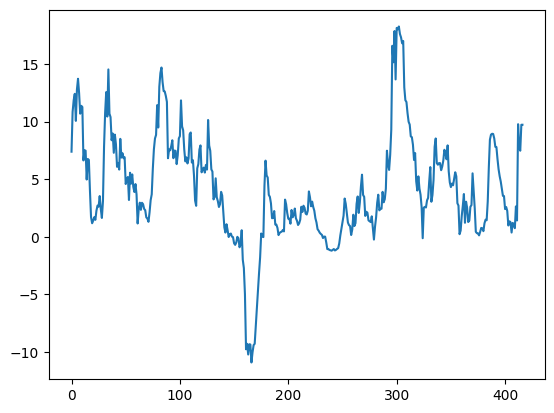

In [ ]:
# how the coefficient of the first parameter (CSENT) changed over time
plt.plot(PA.results['LinR']['1FP']['1MA_1SC']['theta'][:, 0])


In [ ]:
import dash
from dash import Dash, html, dcc, Input, Output, State, ctx
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
# Assuming 'sample' is your DataFrame with the data you want to plot
# And it has columns 'X', 'Y1', 'Y2', ... for your data

# Sample data for three dataframes with similar structure
s1 = pd.DataFrame({
    'X': pd.date_range(start='1/1/2020', periods=100),
    'Y1': np.random.randn(100).cumsum(),
    'Y2': np.random.randn(100).cumsum(),
    'Y3': np.random.randn(100).cumsum()
})
s2 = pd.DataFrame({
    'X': pd.date_range(start='1/1/2020', periods=100),
    'Y1': np.random.randn(100).cumsum()*0.5,
    'Y2': np.random.randn(100).cumsum()*0.5,
    'Y3': np.random.randn(100).cumsum()*0.5
})  # Just for example, modify as needed

s3 = pd.DataFrame({
    'X': pd.date_range(start='1/1/2020', periods=100),
    'Y1': np.random.randn(100).cumsum()*2,
    'Y2': np.random.randn(100).cumsum()*2,
    'Y3': np.random.randn(100).cumsum()*2
})   # Just for example, modify as needed


# Define the number of graphs you want to create
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

# Define colors for traces to ensure consistency across subplots
colors = {'Y1': 'blue', 'Y2': 'red', 'Y3': 'green'}

for i, s in enumerate([s1, s2, s3], start=1):
    for col in ['Y1', 'Y2', 'Y3']:
        fig.add_trace(
            go.Scatter(
                x=s['X'],
                y=s[col],
                name=col,
                mode='lines+markers',
                marker=dict(color=colors[col]),
                showlegend=False, # Only the first subplot shows the legend,
                visible=True
            ),
            row=1, col=i
        )

# Update layout to Plotly's dark theme
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font={'color': 'white'},
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    uirevision='constant' # keeps the user-selected legend state consistent across updates
)


app = dash.Dash(__name__)
# Set up the Dash app layout
app.layout = html.Div([
    html.Div(id='custom-legend', children=[
        html.Button('Y1', id='legend-y1', n_clicks=0),
        html.Button('Y2', id='legend-y2', n_clicks=0),
        html.Button('Y3', id='legend-y3', n_clicks=0)
    ], style={'display': 'flex', 'justifyContent': 'center'}),
    html.Div(style={'width': '600px', 'overflowX': 'scroll'}, children=[
        dcc.Graph(id='subplots-graph', figure=fig, style={'width': '1500px'})
    ])
])


@app.callback(
    output=Output('subplots-graph', 'figure'),
    inputs=dict(
        data=dict(
            y1=Input('legend-y1', 'n_clicks'),
            y2=Input('legend-y2', 'n_clicks'),
            y3=Input('legend-y3', 'n_clicks'),
        ),
    ),
    state=dict(fig=State('subplots-graph', 'figure'))
)
def update_graph_visibility(data, fig):
    # Determine which input was triggered
    triggered_id = ctx.triggered_id

    if triggered_id in {'legend-y1', 'legend-y2', 'legend-y3'}:
        # Get series name (e.g., 'Y1', 'Y2', 'Y3')
        series_name = triggered_id.split('-')[-1]
        # Toggle visibility
        visibility = False if data[series_name] % 2 == 1 else True
    
        # Update traces
        for trace in fig['data']:
            if trace['name'].lower() == series_name:
                trace['visible'] = visibility

    return fig


if __name__ == '__main__':
    app.run_server(debug=True)
